In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

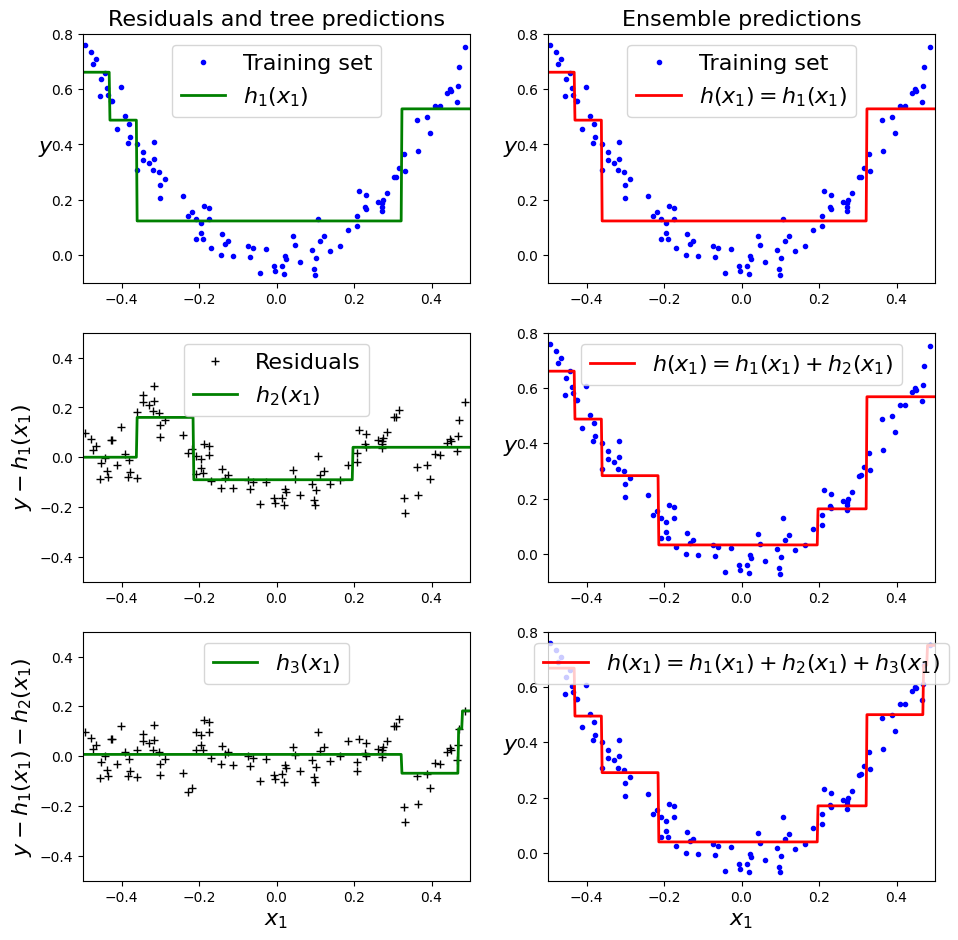

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [19]:
df = pd.read_csv('titanic.csv')

In [20]:
# Display basic information about the dataset
df_info = df.info()
df_summary = df.describe(include="all")

# Show the first few rows
df_head = df.head()

df_info, df_summary, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(None,
         PassengerId    Survived      Pclass                 Name   Sex  \
 count    891.000000  891.000000  891.000000                  891   891   
 unique          NaN         NaN         NaN                  891     2   
 top             NaN         NaN         NaN  Dooley, Mr. Patrick  male   
 freq            NaN         NaN         NaN                    1   577   
 mean     446.000000    0.383838    2.308642                  NaN   NaN   
 std      257.353842    0.486592    0.836071                  NaN   NaN   
 min        1.000000    0.000000    1.000000                  NaN   NaN   
 25%      223.500000    0.000000    2.000000                  NaN   NaN   
 50%      446.000000    0.000000    3.000000                  NaN   NaN   
 75%      668.500000    1.000000    3.000000                  NaN   NaN   
 max      891.000000    1.000000    3.000000                  NaN   NaN   
 
                Age       SibSp       Parch  Ticket        Fare Cabin Embarked  
 count   7

In [21]:
# Drop rows with missing values
df_cleaned = df.dropna()
df_cleaned.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,0.475410,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,0.754617,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


In [23]:
# Display basic information about the dataset
df_cleaned_info = df_cleaned.info()
df_cleaned_summary = df_cleaned.describe(include="all")

# Show the first few rows
df_cleaned_head = df_cleaned.head()

df_cleaned.info, df_cleaned_summary, df_cleaned_head

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


(<bound method DataFrame.info of      PassengerId  Survived  Pclass  \
 1              2         1       1   
 3              4         1       1   
 6              7         0       1   
 10            11         1       3   
 11            12         1       1   
 ..           ...       ...     ...   
 871          872         1       1   
 872          873         0       1   
 879          880         1       1   
 887          888         1       1   
 889          890         1       1   
 
                                                   Name     Sex   Age  SibSp  \
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 6                              McCarthy, Mr. Timothy J    male  54.0      0   
 10                     Sandstrom, Miss. Marguerite Rut  female   4.0      1   
 11                            Bonnell, Miss. Elizabeth  female  58.0      0   
 ..               

**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [28]:
## Separate categorical and numerical features
dfo = df_cleaned.select_dtypes(include=['object'])

# Apply the given transformation
df_encoded = pd.DataFrame(df_cleaned.drop(dfo.columns, axis=1)).merge(
    pd.get_dummies(dfo.drop(['Name', 'Cabin', 'Ticket'], axis=1)),
    left_index=True, right_index=True).drop(['PassengerId'], axis=1)

# Print the shape of the transformed dataset
df_encoded_shape = df_encoded.shape

# Display the transformed dataset


df_encoded.shape



(183, 11)

**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [30]:
# Select categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Convert categorical variables into dummy/indicator variables
df_final = df_cleaned.drop(columns=categorical_cols).merge(pd.get_dummies(df_cleaned[categorical_cols], drop_first=True), left_index=True, right_index=True)

df_final


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,"Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",...,Cabin_E8,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_T,Embarked_Q,Embarked_S
1,2,1,1,38.0,1,0,71.2833,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1,1,35.0,1,0,53.1000,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6,7,0,1,54.0,0,0,51.8625,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10,11,1,3,4.0,1,1,16.7000,False,False,False,...,False,False,False,False,False,False,True,False,False,True
11,12,1,1,58.0,0,0,26.5500,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,47.0,1,1,52.5542,False,False,False,...,False,False,False,False,False,False,False,False,False,True
872,873,0,1,33.0,0,0,5.0000,False,False,False,...,False,False,False,False,False,False,False,False,False,True
879,880,1,1,56.0,0,1,83.1583,False,False,False,...,False,False,False,False,False,False,False,False,False,False
887,888,1,1,19.0,0,0,30.0000,False,False,False,...,False,False,False,False,False,False,False,False,False,True


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [31]:
# Count the number of null values in each column
null_values = df_final.isnull().sum()

# Display columns with null values only
null_values[null_values > 0]


Series([], dtype: int64)

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [32]:
# Define target variable (y) and feature matrix (X)
y = df_final["Survived"]
X = df_final.drop(columns=["Survived"])

# Display the shapes of X and y
X_shape, y_shape = X.shape, y.shape
X_shape, y_shape

((183, 449), (183,))

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [33]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [34]:
from sklearn.model_selection import train_test_split

# Split the data into training (75%) and testing (25%) subsets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Display the shapes of the resulting datasets
X_train_shape, X_test_shape, y_train_shape, y_test_shape = X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train_shape, X_test_shape, y_train_shape, y_test_shape


((137, 449), (46, 449), (137,), (46,))

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [35]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.693
Accuracy score (validation): 0.609

Learning rate:  0.1
Accuracy score (training): 0.701
Accuracy score (validation): 0.609

Learning rate:  0.25
Accuracy score (training): 0.723
Accuracy score (validation): 0.630

Learning rate:  0.5
Accuracy score (training): 0.832
Accuracy score (validation): 0.609

Learning rate:  0.75
Accuracy score (training): 0.810
Accuracy score (validation): 0.609

Learning rate:  1
Accuracy score (training): 0.810
Accuracy score (validation): 0.609



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the learning rates
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

# Store results
results = []

# Train and evaluate Gradient Boosting Classifier with different learning rates
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(
        n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0
    )
    gb.fit(X_train, y_train)
    train_score = gb.score(X_train, y_train)
    test_score = gb.score(X_test, y_test)

    results.append({"Learning Rate": learning_rate, "Training Accuracy": train_score, "Testing Accuracy": test_score})

# Convert results to DataFrame and display


results_df = pd.DataFrame(results)
results_df


,Learning Rate,Training Accuracy,Testing Accuracy
0,0.05,0.693431,0.608696
1,0.10,0.700730,0.608696
2,0.25,0.722628,0.630435
3,0.50,0.832117,0.608696
4,0.75,0.810219,0.608696
5,1.00,0.810219,0.608696


In [39]:
from sklearn.metrics import confusion_matrix, classification_report

# Select the best learning rate based on the highest testing accuracy
best_learning_rate = results_df.loc[results_df["Testing Accuracy"].idxmax(), "Learning Rate"]

# Train the final Gradient Boosting model using the best learning rate
best_gb = GradientBoostingClassifier(
    n_estimators=20, learning_rate=best_learning_rate, max_features=2, max_depth=2, random_state=0
)
best_gb.fit(X_train, y_train)

# Predict on the testing set
y_pred = best_gb.predict(X_test)

# Compute the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
conf_matrix, class_report


(array([[ 1, 17],
        [ 0, 28]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.06      0.11        18\n           1       0.62      1.00      0.77        28\n\n    accuracy                           0.63        46\n   macro avg       0.81      0.53      0.44        46\nweighted avg       0.77      0.63      0.51        46\n')

**<font color='teal'>Calculate the ROC for the model as well.</font>**

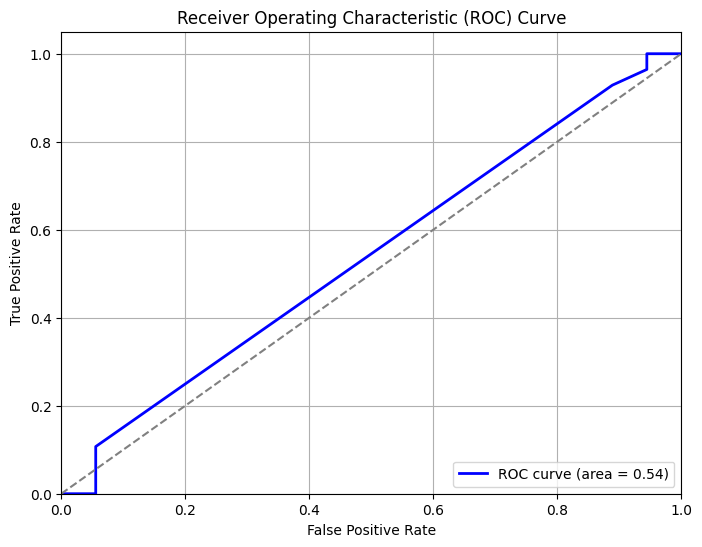

In [41]:
# from sklearn.metrics import roc_curve, auc


# Get the probability scores for the positive class
y_prob = best_gb.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

## Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()

# Show the plot
plt.show()
